In [1]:
import matplotlib.pyplot as plt
import torch
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

from pico import DenoisingDataset, DenoisingModel

[2024-05-09 14:06:24,444] [INFO] [real_accelerator.py:203:get_accelerator] Setting ds_accelerator to cuda (auto detect)
 [WARNING]  async_io requires the dev libaio .so object and headers but these were not found.
 [WARNING]  async_io: please install the libaio-dev package with apt
 [WARNING]  If libaio is already installed (perhaps from source), try setting the CFLAGS and LDFLAGS environment variables to where it can be found.
 [WARNING]  Please specify the CUTLASS repo directory as environment variable $CUTLASS_PATH


/usr/bin/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status


 [WARNING]  sparse_attn requires a torch version >= 1.5 and < 2.0 but detected 2.3
 [WARNING]  please install triton==1.0.0 if you want to use sparse attention


In [2]:
VERSION = "zdf4hd2t"
EPOCH = 3
STEP = 69696

model = DenoisingModel.load_from_checkpoint(
    f"pico/{VERSION}/checkpoints/epoch={EPOCH}-step={STEP}.ckpt",
)

# Load a model with full query capacity
model_full = DenoisingModel.load_from_checkpoint(
    f"pico/{VERSION}/checkpoints/epoch={EPOCH}-step={STEP}.ckpt",
    query_capacity=[1],
)

model.eval()
model_full.eval()

model

DenoisingModel(
  (embedding): Embedding(256, 128)
  (noise_rate_embedding): Linear(in_features=1, out_features=128, bias=True)
  (blocks): ModuleList(
    (0-7): 8 x Block(
      (query_ln): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (value_ln): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (mha): CapacitiveMHA(
        (router): Linear(in_features=128, out_features=1, bias=False)
        (q_rope): RotaryEmbedding()
        (k_rope): RotaryEmbedding()
        (q_proj): Linear(in_features=128, out_features=128, bias=False)
        (kv_proj): Linear(in_features=128, out_features=256, bias=False)
        (out_proj): Linear(in_features=128, out_features=128, bias=False)
      )
      (ffn): Sequential(
        (0): Linear(in_features=128, out_features=256, bias=False)
        (1): SwiGLU()
        (2): Linear(in_features=128, out_features=128, bias=False)
      )
    )
  )
)

In [3]:
dataset = DenoisingDataset(model.hparams["context_len"], model.hparams["noise_levels"])

## Visualizing embeddings with t-SNE

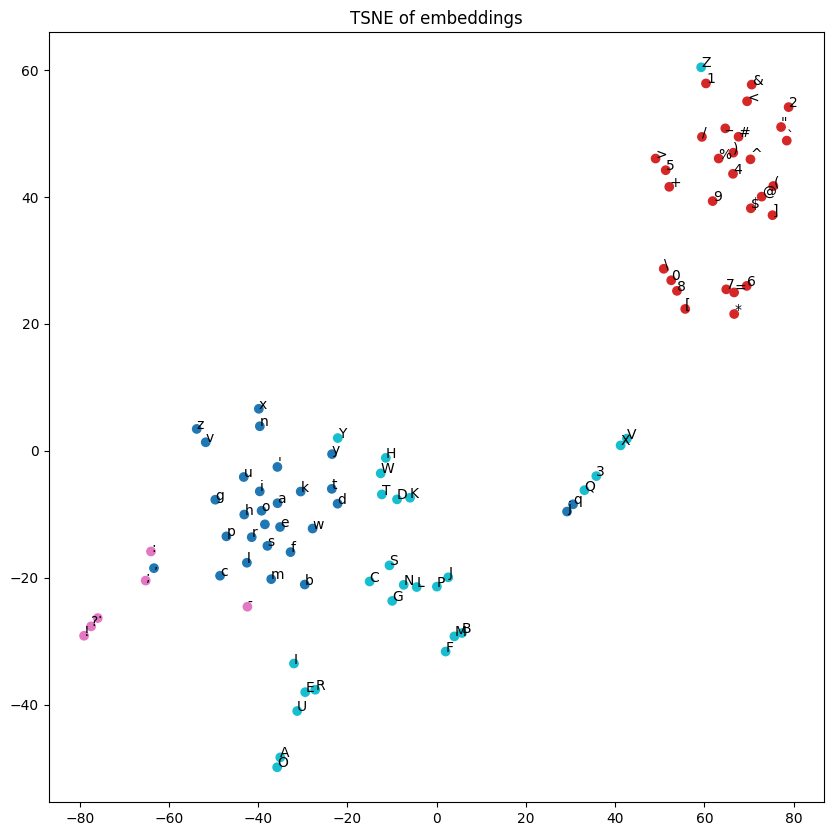

In [4]:
# Get the embeddings of bytes section corresponding to alphanumerical ASCII characters
embeddings = model.embedding.weight.detach().cpu().numpy()
embeddings = embeddings[32:123]
embeddings_labels = [chr(i) for i in range(32, 123)]

tsne = TSNE(n_components=2, perplexity=2, n_iter=30000)
embeddings_tsne = tsne.fit_transform(embeddings)

cluster = KMeans(n_clusters=4)
cluster.fit(embeddings)

# Plot
plt.figure(figsize=(10, 10))
plt.title("TSNE of embeddings")

plt.scatter(
    embeddings_tsne[:, 0], embeddings_tsne[:, 1], c=cluster.labels_, cmap="tab10"
)

for i, label in enumerate(embeddings_labels):
    plt.annotate(label, (embeddings_tsne[i, 0], embeddings_tsne[i, 1]))

## Visualizing dynamic compute allocation

Pico models use Mixture-of-Depths like dynamic compute. Here we visualize which tokens gets skipped by the self attention mechanism in the transformer layer.

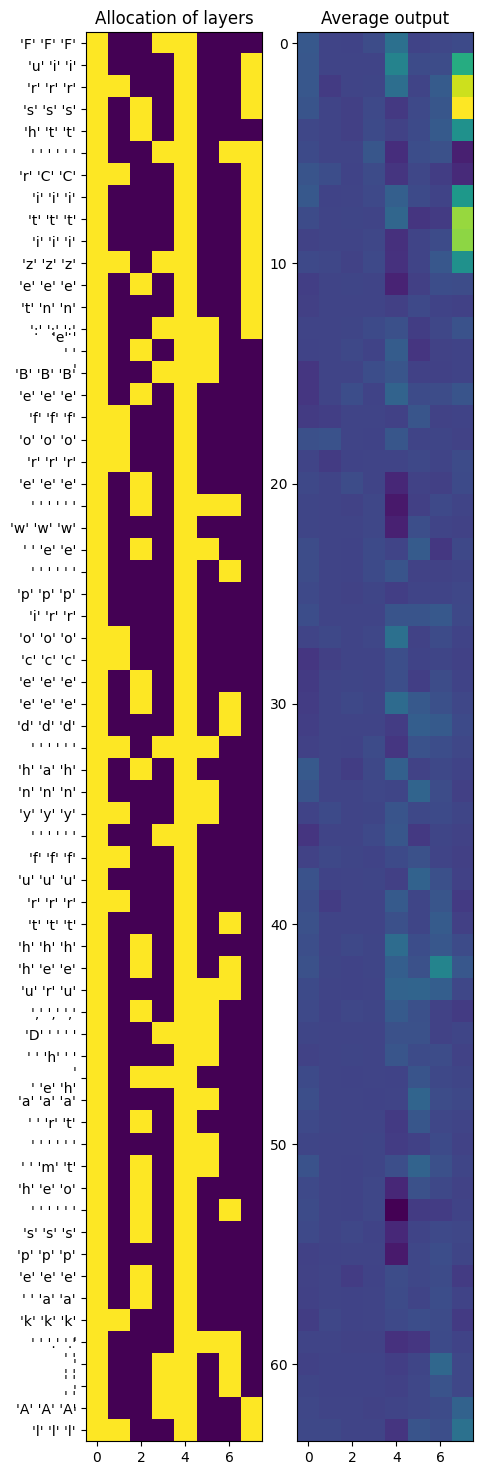

In [5]:
# Find a low noise dataset entry
for entry in dataset:
    y, x, noise = entry

    if 0.3 <= noise <= 0.4:
        x = x.unsqueeze(0).cuda()
        noise = torch.tensor([noise]).cuda()
        break

x_text = bytes(x[0].cpu().tolist()).decode("utf-8")
y_text = bytes(y.cpu().tolist()).decode("utf-8")

pred, attention = model(x, noise, return_attention=True)
_, attention_full = model_full(x, noise, return_attention=True)

attention = attention[0].detach().cpu().numpy()
attention_full = attention_full[0].detach().cpu().numpy()

attention = (attention.var(axis=-1) != 0).T[:64]
attention_full = attention_full.mean(axis=-1).T[:64]

pred_text = bytes(pred[0].argmax(dim=-1).cpu().tolist()).decode("utf-8")

plt.figure(figsize=(5, 20))

plt.subplot(1, 2, 1)
plt.title("Allocation of layers")

plt.imshow(attention)
plt.yticks(
    range(64),
    [
        f"'{a}' '{b}' '{c}'"
        for a, b, c in zip(x_text[:64], y_text[:64], pred_text[:64])
    ],
)

plt.subplot(1, 2, 2)
plt.title("Average output")

plt.imshow(attention_full)